In [12]:
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt
import pandas as pd
from pybaselines import Baseline, utils


Current data is shaped: (1250, 100, 514)


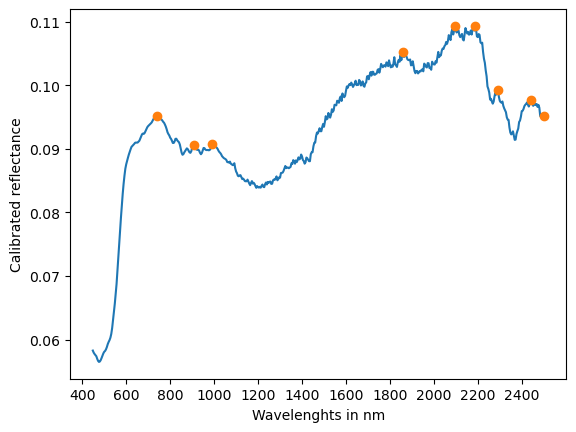

In [5]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 50
curr_y = 54

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')
plt.xticks(np.arange(400,2500, step = 200))

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel,
                   width = 5)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

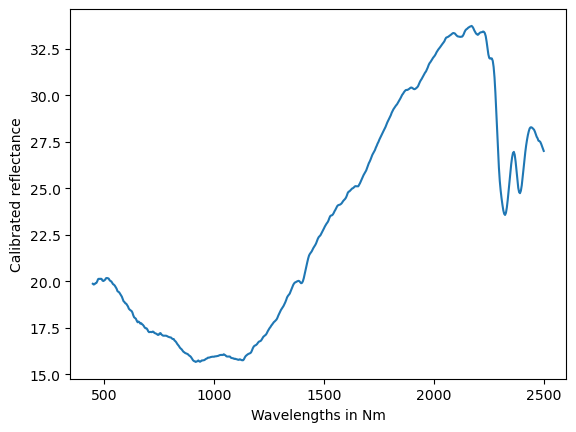

In [9]:
# Shoehorn in the loading of a standard reference spectrum instead 

ref_data = pd.read_csv('reference_lib/Amphibole_03.csv')
wav_array = ref_data.iloc[:,0].values
curr_pixel =  ref_data.iloc[:,1].values

plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelengths in ' + 'Nm')
plt.ylabel('Calibrated reflectance')

# Master peak ranges
# This data will need to be committed to a database table so that it can be extracted
# in a more easily edited central location
min_list = np.sort(np.asarray([820, 2490, 645, 790, 880, 1370, 1450, 1465, 1535, 1710, 1890, 1935, 2145, 2185, 2230, 2220, 2270, 2325, 2345, 2375]))
max_list = np.sort(np.asarray([980, 2550, 675, 810, 1150, 1420, 1490, 1500, 1565, 1785, 1940, 1960, 2185, 2230, 2265, 2300, 2330, 2370, 2390, 2415]))
mineral_label = ['iron oxides (goethite, hematite)', 'carbonates', 'molybdenite', 
                 'REE', 'pyroxene', 'micas, clays', 'jarosite', 'alunite', 
                 'epidote', 'sulphates', 'all OH, zeo', 'gypsum',
                 'pyrophyllite', 'Al-OH', 'chlorite, biotite', 'Al-fe smectites', 
                 'Fe-Mg smectites', 'chlorite, biotite', 'tourmaline', 'amphiboles, biotite']
hull_correct_bool = [False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]

In [37]:
class HullRemoval:
    def __init__(self,
                 x_data,
                 y_data,
                invert_data = True,
                do_plots = True):
        self.x_data = x_data
        self.y_data = y_data
        self.baseline_fitter = Baseline(x_data,
                                        check_finite=False)
        # Get the peaks of the current spectrum
        self.peaks = find_peaks(y_data,
                   width = 5)[0]
        # Append the end of the spectrum
        self.peaks = np.append(self.peaks,
                               self.y_data.shape[0]-1)
        self.do_plots = do_plots

    def interpolate_linear(self,
                           spectrum,
                           indices):
        # Create an interpolation function based on the given indices
        interp_func = interp1d(indices,
                               spectrum[indices],
                               fill_value="extrapolate")
        # Apply the interpolation function to the entire range of indices
        lower_hull = interp_func(np.arange(len(spectrum)))
        return lower_hull
    
    def calculate_baseline(self):

        # Invert the data 
        pix_inverse = 1 / self.y_data 
        
        # Calculate the baseline
        baseline_inv = baseline_fitter.snip(pix_inverse,
                                     max_half_window=40,
                                     decreasing=True,
                                     smooth_half_window=0)[0]
        
        # Invert the result
        self.curr_baseline = 1 / baseline_inv

        if self.do_plots:
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.curr_baseline,
                     label='Calculated Baseline')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
            
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data/self.curr_baseline,
                     label='Hull Quotient')
            plt.legend()

    def calculate_initial_hull(self):
        prelim_hull = self.interpolate_linear(self.y_data[self.peaks[0]:],
                                              self.peaks - self.peaks[0])

        self.concat_hull = np.concatenate((self.curr_baseline[0:self.peaks[0]],
                                      prelim_hull))

        self.initial_quotient = self.y_data/self.concat_hull

        if self.do_plots:
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.concat_hull,
                     label='Hybrid Baseline')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
            
            plt.figure()
            plt.plot(self.x_data,
                     self.initial_quotient,
                     label='Initial Hull Quotient')
            plt.legend()

    def iterate_final_hull(self):
        curr_quotient = self.initial_quotient
        n_gt_one = (curr_quotient > 1.01).sum()
        count = 0
        while n_gt_one > 0:
            curr_index_to_add = curr_quotient.argmax()
            # Append this index to the peaks
            self.peaks = np.unique(np.sort(np.append(self.peaks,
                                                     curr_index_to_add)))
            
            
            prelim_hull = self.interpolate_linear(self.y_data[self.peaks[0]:],
                                             self.peaks - self.peaks[0])
            
            self.final_concat_hull = np.concatenate((self.curr_baseline[0:self.peaks[0]],
                                          prelim_hull))
        
            
            curr_quotient = self.y_data/self.final_concat_hull
            n_gt_one = (curr_quotient > 1).sum()
            count +=1
            if count > 20:
                print('Too many iterations, breaking loop')
                n_gt_one = -1
        if self.do_plots:
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.final_concat_hull,
                     label='Final Iterative Hull')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
            
            plt.figure()
            plt.plot(self.x_data,
                     curr_quotient,
                     label='Final Hull Quotient')
            plt.legend()
        self.final_quotient = curr_quotient

    def make_quotient(self):
        self.calculate_baseline()
        self.calculate_initial_hull()
        self.iterate_final_hull()
        return self.final_quotient
        


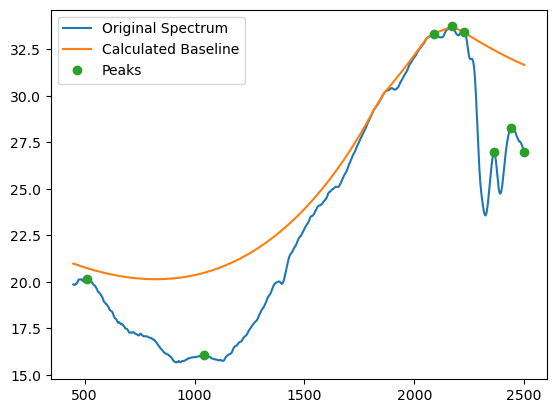

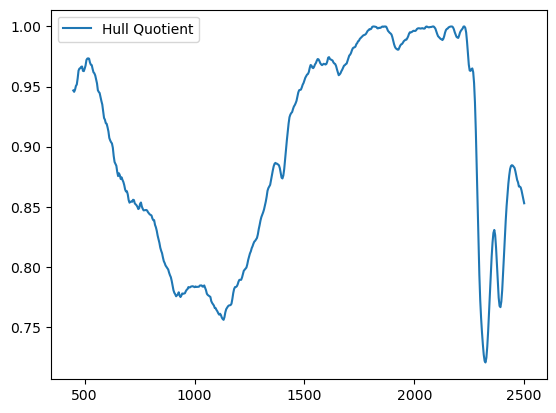

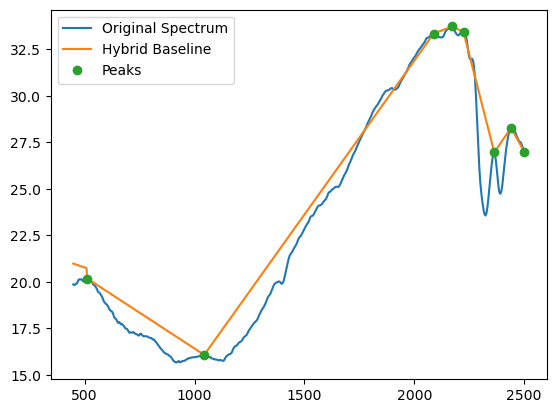

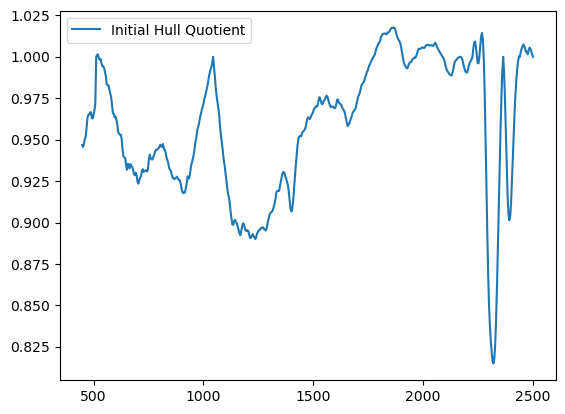

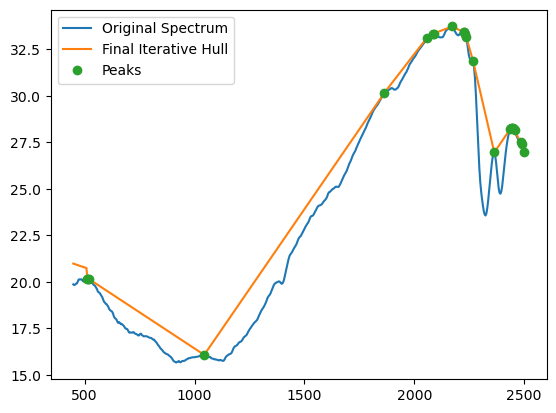

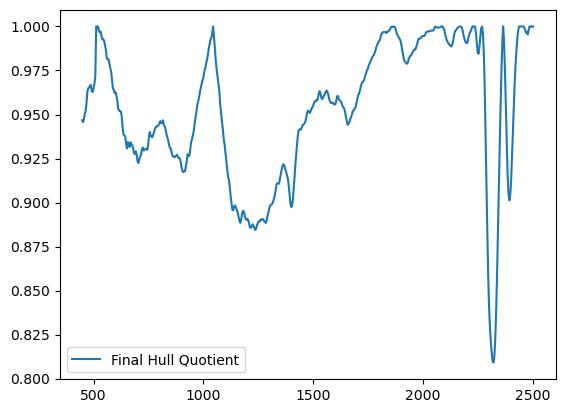

In [35]:
hr = HullRemoval(wav_array, curr_pixel, do_plots = True)
hr.calculate_baseline()
hr.calculate_initial_hull()
hr.iterate_final_hull()